<a href="https://colab.research.google.com/github/spsc0894/FaceMaskDetection/blob/main/FaceMaskDetection_fasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andrewmvd/face-mask-detection

 98% 390M/398M [00:04<00:00, 94.6MB/s]
100% 398M/398M [00:04<00:00, 99.4MB/s]


In [ ]:
!pip install pycocotools --quiet
!rm -rf vision && git clone https://github.com/pytorch/vision.git
!cd vision && git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 34034, done.
remote: Counting objects: 100% (6577/6577), done.
remote: Compressing objects: 100% (1326/1326), done.
remote: Total 34034 (delta 5278), reused 6299 (delta 5121), pack-reused 27457
Receiving objects: 100% (34034/34034), 44.52 MiB | 30.95 MiB/s, done.
Resolving deltas: 100% (25888/25888), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
!ls

coco_eval.py   drive	  face-mask-detection.zip  transforms.py  vision
coco_utils.py  engine.py  sample_data		   utils.py


In [ ]:
!unzip face-mask-detection.zip 

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

In [ ]:
import numpy as np
import os

images=[image for image in os.listdir('images/') if image[-4:]=='.png']
print(len(images))

853


In [ ]:
rand_index=np.random.permutation(len(images))
! mkdir test && mkdir train

In [ ]:
import shutil
test_size=int(0.2*853)
test_images=[images[i] for i in rand_index[0:test_size]]
train_images=list(set(images)-set(test_images))
for i,img in enumerate(test_images):
  shutil.copy('images/'+img, f'test/{i}.png')
  xml=img[:-4]+'.xml'
  shutil.copy('annotations/'+xml, f'test/{i}.xml')
for i,img in enumerate(train_images):
  shutil.copy('images/'+img, f'train/{i}.png')
  xml=img[:-4]+'.xml'
  shutil.copy('annotations/'+xml, f'train/{i}.xml')


In [ ]:

! ls train

0.png	 169.png  237.png  305.png  374.png  442.png  510.png  57.png	648.png
0.xml	 169.xml  237.xml  305.xml  374.xml  442.xml  510.xml  57.xml	648.xml
100.png  16.png   238.png  306.png  375.png  443.png  511.png  580.png	649.png
100.xml  16.xml   238.xml  306.xml  375.xml  443.xml  511.xml  580.xml	649.xml
101.png  170.png  239.png  307.png  376.png  444.png  512.png  581.png	64.png
101.xml  170.xml  239.xml  307.xml  376.xml  444.xml  512.xml  581.xml	64.xml
102.png  171.png  23.png   308.png  377.png  445.png  513.png  582.png	650.png
102.xml  171.xml  23.xml   308.xml  377.xml  445.xml  513.xml  582.xml	650.xml
103.png  172.png  240.png  309.png  378.png  446.png  514.png  583.png	651.png
103.xml  172.xml  240.xml  309.xml  378.xml  446.xml  514.xml  583.xml	651.xml
104.png  173.png  241.png  30.png   379.png  447.png  515.png  584.png	652.png
104.xml  173.xml  241.xml  30.xml   379.xml  447.xml  515.xml  584.xml	652.xml
105.png  174.png  242.png  310.png  37.png   448.png  516.pn

In [ ]:
! touch vision/__init__.py
!ls vision/

docs	    __init__.py  MANIFEST.in  references  setup.py  torchvision
hubconf.py  LICENSE	 README.rst   setup.cfg   test	    tox.ini


In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 98 kB 5.3 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
albumentations==1.0.3 is successfully installed


In [ ]:
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
files_dir = 'train'
test_dir = 'test'

In [ ]:
!cat train/1.xml


<annotation>
    <folder>images</folder>
    <filename>maksssksksss483.png</filename>
    <size>
        <width>400</width>
        <height>267</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>115</xmin>
            <ymin>47</ymin>
            <xmax>157</xmax>
            <ymax>87</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>186</xmin>
            <ymin>90</ymin>
            <xmax>231</xmax>
            <ymax>130</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</trunca

In [ ]:
torch.set_default_dtype(torch.float32)
class FaceMaskDataset(torch.utils.data.Dataset):
    def __init__(self,files_dir,height,width,transforms=None):
        self.files_dir=files_dir
        self.height=height
        self.width=width
        self.images=[img for img in os.listdir(self.files_dir) if img[-4:]=='.png']
        self.classes=['_','with_mask','without_mask','mask_weared_incorrect']
        self.transforms=transforms

    def __getitem__(self,idx):
        img_name=self.images[idx]
        img_path=os.path.join(self.files_dir,img_name)
        img=cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res= cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0
        '''
        if self.transforms:
            img_res = self.transforms(img_res)
        '''

        annotation_file=img_name[:-4]+'.xml'
        annot_file_path=os.path.join(self.files_dir,annotation_file)
        bboxes=[]
        labels=[]
        tree=et.parse(annot_file_path)
        root=tree.getroot()

        wt=img.shape[1]
        ht=img.shape[0]

        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            xmin=int(member.find('bndbox').find('xmin').text)
            ymin=int(member.find('bndbox').find('ymin').text)
            xmax=int(member.find('bndbox').find('xmax').text)
            ymax=int(member.find('bndbox').find('ymax').text)
            xmin=xmin if xmin>=0 else 0
            xmax=xmax if xmax<=wt-1 else wt-1
            ymin=ymin if ymin>=0 else 0
            ymax=ymax if ymax<ht-1 else ht-1

            xmin_corr=(xmin/wt)*self.width
            xmax_corr=(xmax/wt)*self.width
            ymin_corr=(ymin/ht)*self.height
            ymax_corr=(ymax/ht)*self.height

            bboxes.append([xmin_corr,ymin_corr,xmax_corr,ymax_corr])
        bboxes=torch.as_tensor(bboxes,dtype=torch.float32)
        area=(bboxes[:,3]-bboxes[:,1])*(bboxes[:,2]-bboxes[:,0])
        area = torch.as_tensor(area, dtype=torch.float32)
        is_crowd=torch.zeros((bboxes.shape[0],),dtype=torch.int64)
        labels=torch.as_tensor(labels,dtype=torch.int64)
        target= {}
        target['boxes']=bboxes
        target['area']=area
        target['iscrowd']=is_crowd
        target['labels']=labels
        img_id=torch.tensor(idx)
        target['image_id']=img_id
        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        return img_res,target,img_id


    def __len__(self):
        return len(self.images)

In [ ]:
dataset=FaceMaskDataset(files_dir,224,224)
print('length of dataset:',len(dataset))

img, target,img_id = dataset[78]
print(img.shape, '\n',target)


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth=2,
                                 edgecolor='r',
                                 facecolor='none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

length of dataset: 683
(224, 224, 3) 
 {'boxes': tensor([[ 71.6800,  48.7200, 161.2800, 119.8400]]), 'area': tensor([6372.3516]), 'iscrowd': tensor([0]), 'labels': tensor([1]), 'image_id': tensor(78)}


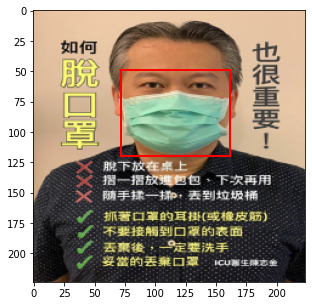

In [ ]:
plot_img_bbox(img,target)

In [ ]:
def get_object_detection_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=3)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

'''
from torchvision import transforms
tensor_transform = transforms.Compose([transforms.ToTensor()])
'''
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset = FaceMaskDataset(files_dir, 480, 480, transforms= get_transform(True))
dataset_test = FaceMaskDataset(files_dir, 480, 480, transforms= get_transform(False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
'''
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
'''
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0)

# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
num_classes = 4
torch.autograd.set_detect_anomaly(True)
# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                               step_size=3,
#                                               gamma=0.1)

# training for 10 epochs
num_epochs = 50
losses_plot={'loss_classifier': [], 'loss_box_reg': [], 'loss_objectness': [], 'loss_rpn_box_reg': []}
for epoch in range(num_epochs):
    ld=0
    epoch_loss=0
    #train_data_loader = tqdm.tqdm(data_loader)
    #d_l=len(train_data_loader)
    for images, targets, image_ids in data_loader:
        ld+=1
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        l=[loss for loss in loss_dict.values()]
        losses_plot['loss_classifier'].append(float(l[0].data.cpu().numpy()))
        losses_plot['loss_box_reg'].append(float(l[1].data.cpu().numpy()))
        losses_plot['loss_objectness'].append(float(l[2].data.cpu().numpy()))
        losses_plot['loss_rpn_box_reg'].append(float(l[3].data.cpu().numpy()))

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
        epoch_loss += losses
    print(epoch+1, '/', num_epochs, ' : {:.5f}'.format(epoch_loss/ld))
    if epoch_loss/ld < 0.1 :
        print('early stop')
        break
        
'''

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model.float(), optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test datasetq
    evaluate(model, data_loader_test, device=device)
'''

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



1 / 50  : 0.41662
2 / 50  : 0.29276
3 / 50  : 0.24943
4 / 50  : 0.21800
5 / 50  : 0.19427
6 / 50  : 0.17569
7 / 50  : 0.15870
8 / 50  : 0.14571
9 / 50  : 0.13441
10 / 50  : 0.12388
11 / 50  : 0.11583
12 / 50  : 0.10620
13 / 50  : 0.10502
14 / 50  : 0.09583
early stop


'\n\nfor epoch in range(num_epochs):\n    # training for one epoch\n    train_one_epoch(model.float(), optimizer, data_loader, device, epoch, print_freq=10)\n    # update the learning rate\n    lr_scheduler.step()\n    # evaluate on the test datasetq\n    evaluate(model, data_loader_test, device=device)\n'

In [ ]:
torch.save(model.state_dict(), 'FaceMaskDetection_FRCNN.pt')

In [ ]:
model = get_object_detection_model(4).to(device)
model.load_state_dict(torch.load('FaceMaskDetection_FRCNN.pt'))

<All keys matched successfully>

In [ ]:
img,target,img_id = data_loader_test.dataset[8]
with torch.no_grad():
  model.eval()
  outputs = model(img.unsqueeze(0).to(device))
  boxes = outputs[0]['boxes'].data.cpu().numpy()
  scores = outputs[0]['scores'].data.cpu().numpy()
  boxes = boxes[scores >= 0.5].astype(np.int32)
  scores = scores[scores >= 0.5]
  labels= outputs[0]['labels']

In [ ]:
scores = outputs[0]['scores'].data.cpu().numpy()
scores

array([0.99964297], dtype=float32)

In [ ]:
boxes= outputs[0]['boxes'].data.cpu().numpy()

In [ ]:
boxes

array([[274.52756, 131.04387, 367.31647, 270.12537]], dtype=float32)

In [ ]:

boxes = boxes[scores >= 0.5].astype(np.int32)

In [ ]:
boxes

array([[274, 131, 367, 270]], dtype=int32)

In [ ]:
labels= outputs[0]['labels'].data.cpu().numpy()
labels=labels[scores >= 0.5].astype(np.int32)

In [ ]:
labels

array([1], dtype=int32)

In [ ]:
img.shape

torch.Size([3, 480, 480])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


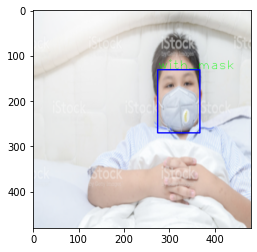

In [ ]:
mapping=['_','with_mask','without_mask','mask_weared_incorrect']
import matplotlib.pyplot as plt

img=cv2.cvtColor(img.cpu().detach().numpy().transpose(1,2,0),cv2.COLOR_RGB2BGR)
for i,b in enumerate(boxes):
    cv2.rectangle(img,(b[0],b[1]),(b[2],b[3]),(255,0,0),2)
    cv2.putText(img,mapping[labels[i]],(b[0],b[1]),1,2,(0,255,0),1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [ ]:
gt_boxes=target['boxes']

In [ ]:
gt_boxes.int().numpy()

array([[276, 126, 367, 273]], dtype=int32)

In [ ]:
target['labels']

tensor([1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


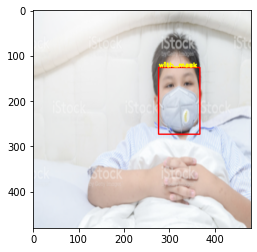

In [ ]:
img,target,img_id = data_loader_test.dataset[8]
img=cv2.cvtColor(img.cpu().detach().numpy().transpose(1,2,0),cv2.COLOR_RGB2BGR)
for i,b in enumerate(target['boxes'].int().numpy()):
    cv2.rectangle(img,(b[0],b[1]),(b[2],b[3]),(0,0,255),2)
    cv2.putText(img,mapping[target['labels'][i]],(b[0],b[1]),1,1,(0,255,255),2)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

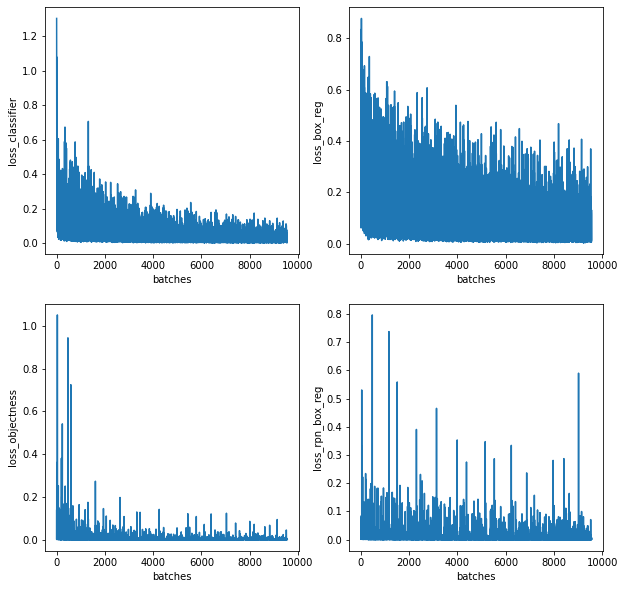

In [ ]:
plt.figure(figsize=(10,10))
for i,plots in enumerate(['loss_classifier','loss_box_reg', 'loss_objectness','loss_rpn_box_reg']):
  plt.subplot(2,2,i+1)
  plt.plot(losses_plot[plots])
  plt.ylabel(plots)
  plt.xlabel('batches')
plt.show()